In [2]:
# Install keras-vis
!pip install keras-vis

In [3]:
#set-up permissions for Colaboratory to access my Google Drive 
# allows me to load and save models and save visualizations
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass

!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
#mounts my Googledrive as drive
!mkdir -p drive
!google-drive-ocamlfuse drive


In [5]:

#simple check to make sure everything is set-up
!ls 'drive/Colab Notebooks/MSIM607FinalProject'



EvolutionFirst5Gens
FilterSaliency-conv2_1-51-inferno-relu-guided.jpg
FilterSaliency-conv2_2-51-inferno-relu-guided.jpg
FilterSaliency-conv2_3-18-inferno-relu-guided.jpg
FilterSaliency-conv2_3-51-inferno-relu-guided.jpg
MINIST_SecondRound.ipynb
model-l10-e12-b64-asoftmax-oadadelta-k332v1.h5
model-l10-e12-b64-asoftmax-oadadelta-k432.h5
model-l10-e12-b64-asoftmax-oadadelta-k432v1.h5
model-l10-e12-b64-asoftmax-oadadelta-k432v2.h5
model-l10-e12-b64-asoftmax-oadam-k432.h5
model-l10-e5-b64-asoftmax-oadam-k432.h5
model-l11-e12-b64-asoftmax-oadadelta.h5
model-l12-e12-b64-asoftmax-oadadelta-k432.h5
NetworkCreationTest.ipynb
parents
Saliency-18-class3-relu-guided.jpg
Saliency-18-class8-relu-guided.jpg
Saliency-18-inferno-class3-relu-guided.jpg
Saliency-18-inferno-class8-relu-guided.jpg
Saliency-51-class3-negate-guided.jpg
Saliency-51-class3-none-guided.jpg
Saliency-51-class3-none-relu.jpg
Saliency-51-class3-relu-guided.jpg
Saliency-51-class3-relu-none.jpg
Saliency-51-class3-relu-relu.jpg
Salienc

In [6]:

#imports keras and other libraries
import keras
from keras.datasets import mnist
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import imagenet_utils 
from keras.preprocessing import image
from keras import backend as K
from sklearn.preprocessing import OneHotEncoder
from matplotlib.pyplot import imshow
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.ndimage as ndimage
from keras.models import model_from_yaml
from keras import activations,layers

import random


# input image dimensions
img_rows, img_cols = 28, 28

num_classes = 10

Using TensorFlow backend.


In [0]:
#import keras-vis libraries
from vis.losses import ActivationMaximization
from vis.regularizers import TotalVariation, LPNorm
from vis.input_modifiers import Jitter
from vis.optimizer import Optimizer
from vis.callbacks import GifGenerator
from vis.visualization import visualize_activation, get_num_filters
from vis.visualization import visualize_saliency
from vis.visualization import visualize_cam
from vis.utils import utils

In [0]:

#changing activation to linear on output layer for keras-vis visualizations
def SoftMax2Linear(model):
  model2 = model
  model2.layers[utils.find_layer_idx(model, 'predict')].activation = activations.linear
  model3 = utils.apply_modifications(model2)
  return model3

#places visualization into a grid position.  
def render_img_on_grid(img, pos, grid):
    if (pos == 0):
      plt.set_cmap('Greys')  # for original image
    else:
      plt.set_cmap('inferno')  # for all other images

    ax = plt.subplot(grid[pos])
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

In [0]:

# predict class of image.  Used for visualizations to supply seed_input
def classOfImage(img_no):
  
  img_no = 0
  x = image.img_to_array(np.reshape(x_test[img_no],(28,28)))
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  return model.predict_classes(images)



In [0]:
#subtracts mean from image
def subtract_mean_image(img):
  mn = np.mean(img)
  tmp = img - mn  
  return tmp

#centers data in image.  Used to normalize images
def center_data(dat):
  idr,m,n,v = dat.shape
  for i in range(idr):
    dat[i] = subtract_mean_image(dat[i])
  return dat

#gets number of model layer.  used in visualizations
def outputLayerIndex(model,name):
  lyr = [(layer.name, layer) for layer in model.layers[0:]]
  ly_idx = 0
  for id,(nm,ly) in enumerate(lyr):
    if nm == name:
      ly_idx = id
      break
  return ly_idx
    

#test = outputLayerIndex(population[0],'dropout_1')
#lyr = [(layer.name, layer) for layer in model.layers[0:]]
#lyr

In [11]:

#loads testing and training data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#reshapes data into correct format
if K.image_data_format() == 'channels_first':
    print('channel format')
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    print('something else')
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols,1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


# converts class vectors into class categories
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#normalizes images
x_train = center_data(x_train)
x_test = center_data(x_test)


11493376/11490434 [==============================] - 4s 0us/step
something else
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [0]:
# all model parameters and their values that can be selected for genetic algorithm "gene pool"
#returns list is the chromosome order
# conv2d_1 kernel size, conv2d_1 filters, conv2d_2 kernel size, conv2d_2 filters, conv2d_3 kernel size, conv2d_3 filters
# conv2d_1 strides, dropout_1, dropout_2, Nh for output layer, optimizer, epochs

def create_evolution_list():
  filters_opt = [32,64,128,256,512]
  strides_opt = [1,2]
  kernel_opt = [2,3,4]
  dropout_opt = [.2,.3,.4,.5]
  optimizer_opt = [keras.optimizers.Adadelta(),keras.optimizers.Adam()]
  epochs_opt = [6,12,18]
  Nh_opt = [128,256,512]
  
  return [kernel_opt,filters_opt[0:3],kernel_opt,filters_opt[0:3],kernel_opt,filters_opt, strides_opt,dropout_opt,dropout_opt,Nh_opt,optimizer_opt,epochs_opt]

#creates count number of individuals randomly
def create_population(count):
  pop = []                         # list of models created
  pop_epochs = []                  # epochs of each model in same order as models in pop list
  for _ in range(0, count):
    # Create a random network.
    rand_params = selectParams(evolution_list)
    pop_epochs.append(rand_params[11])
    pop.append(individual(rand_params))
    print("network added")
  return pop, pop_epochs

#allows one to load up a set of models that is saved
#must be manually edited before running.
def load_population(count):
  pop = []
  pop_epochs = []
  pop_epochs = [18,12,12,18,12,12,12,12,12,6,12,12,12,12,18,18,12,12,6,18]  # currently need to type in manually from saved word document - not automatically saves
  for i in range(0,count):
    pop.append(load_model("drive/Colab Notebooks/MSIM607FinalProject/EvolutionFirst5Gens/model-" + str(i) + '.h5'))  #enter directory of saved files
  return pop, pop_epochs

In [20]:
#initializes gene pool and starting population
evolution_list = create_evolution_list()
population_epochs = []
count = 20;
population=[]

population, population_epochs = create_population(count)  # start evolution from scratch
#population, population_epochs = load_population(count)  # start evoluation from saved files (with manual entry of epochs and directory location into function)

/usr/local/lib/python3.6/dist-packages/keras/models.py:291: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [0]:
#performs the evolution through the generations
generations = 5
parents = population
parents_epochs = population_epochs

for _ in range(0,generations):
  parents, parents_epochs = evolve(parents,parents_epochs)

#at the end of the evoluation process save all of the models created.
for i in np.arange(len(parents)):
   parents[i].save( "drive/Colab Notebooks/MSIM607FinalProject/parents/model-" + str(i) + '.h5')  # creates a HDF5 file 'my_model.h5'

#since evolution performs fitness at beginning of generation, results from last generation needs to be printed separately
for i in np.arange(len(parents)):
   get_params(parents[i],parents_epochs[i])
   print("Fitness:", fitness(parents[i]))

population [<keras.models.Sequential object at 0x7f40ef4caf28>, <keras.models.Sequential object at 0x7f40ef4cada0>, <keras.models.Sequential object at 0x7f40ef4ca780>, <keras.models.Sequential object at 0x7f40d5a48400>, <keras.models.Sequential object at 0x7f40d4097c88>, <keras.models.Sequential object at 0x7f40d30cfe48>, <keras.models.Sequential object at 0x7f40cc07ba20>, <keras.models.Sequential object at 0x7f40cb78c4e0>, <keras.models.Sequential object at 0x7f40caf7bfd0>, <keras.models.Sequential object at 0x7f40ca055b38>, <keras.models.Sequential object at 0x7f40ca3f9be0>, <keras.models.Sequential object at 0x7f40ce43ec18>, <keras.models.Sequential object at 0x7f40c4d96c50>, <keras.models.Sequential object at 0x7f40c429bcc0>, <keras.models.Sequential object at 0x7f40c2197fd0>, <keras.models.Sequential object at 0x7f40c1b865f8>, <keras.models.Sequential object at 0x7f40c11ab5c0>, <keras.models.Sequential object at 0x7f40ba4882b0>, <keras.models.Sequential object at 0x7f40ba470cf8>, 

In [0]:
# mutation
def mutate(network,epoch):

  # get model parameters from selected individual
  param_list = get_params(network,epoch)
  
  # select parameter to mutate
  param_to_mutate = random.choice(np.arange(0,len(evolution_list)-1)) #epochs will NOT be mutated
  # select replacement value randomly from gene pool
  selection = random.choice(evolution_list[param_to_mutate])
  print("param_to_mutate:", param_to_mutate, "  New Value:",selection)
  
  #replace old value in chromosome with new value
  param_list[param_to_mutate]=selection

  return individual(param_list)  # return a newly trained network


# create a new network by randomly picking parameters from parent networks
# model parameters are passed into function NOT keras models
def breed(male, female):
#order expected kernel1, filters1, k+f2, k+f3, strides, dropout1, dropout2, Nh, optimizer, epochs
  
  child_params = []
  #for each parameter needed for the child,  randomly select it from one of the parents
  for i in range(0,len(male)):
    child_params.append(random.choice([male[i], female[i]]))
 
  print(child_params)
  return individual(child_params), child_params[11]  # return newly trained child network and its epoch



#  evolution algorithm
# evaluate each network for fitness
# take the top 25% automatically for producing next generation
# give each of the remaining networks a 25% chance of being kept to move on
# of the above networks,  each have a 15% chance of being mutated.
# create children to replace the networks rejected by randomly picking genes from two randomly selected parents

def evolve(population, pop_epochs):
  print("population", population)
  print("pop_epochs", pop_epochs)
  keep = 5 

  random_select = .25
  mutate_chance = .15

  # Get scores for each network.
  ranking = [(fitness(network), network) for network in population]
  print(ranking)
  # Sort on the scores.
  ranked = [x[1] for x in sorted(ranking, key=lambda x: x[0], reverse=True)]
  print(ranked)
  
  p_epochs_ranked=[]
  #match epochs to new sorted network arrangement
  for i in np.arange(len(ranked)):
    p_epochs_ranked.append(pop_epochs[population.index(ranked[i])])

  # The parents are every network we want to keep.
  parents = ranked[:keep]
  parents_epochs = p_epochs_ranked[:keep]
  # For those we aren't keeping, randomly keep some anyway.
  for each_net in ranked[keep:]:
      if random_select > random.random():
          parents.append(each_net)
          parents_epochs.append(p_epochs_ranked[ranked.index(each_net)])

  # Randomly mutate some of the networks we're keeping.
  for idx in np.arange(len(parents)):
      if mutate_chance > random.random():
          parents[idx] = mutate(parents[idx],parents_epochs[idx])
          print("IDX",idx)
  print(parents)

  # Now find out how many spots we have left to fill.
  parents_length = len(parents)
  desired_length = len(population) - parents_length

  children = []
  children_epochs = []
  # Add children, which are bred from two remaining networks.
  while len(children) < desired_length:
      # Get a random mom and dad.
      male = random.choice(parents)
      female = random.choice(parents)
      print(male,female)

      # Assuming they aren't the same network...
      if male != female:
        #create chromosome for each parent
        male_epoch = parents_epochs[parents.index(male)]
        female_epoch = parents_epochs[parents.index(female)]
        male_params = get_params(male, male_epoch)
        female_params = get_params(female,female_epoch)
        #create new network
        baby,baby_epoch=breed(male_params,female_params)
        children.append(baby)
        children_epochs.append(baby_epoch)

  #add children to parent list to complete new generation
  parents.extend(children)
  parents_epochs.extend(children_epochs)
  print(parents)
  print(parents_epochs)
  
  return parents, parents_epochs

In [0]:
#randomly selects a value for each parameter
#used to randomly select from gene pool
def selectParams(param_list):
  
  params = []
  for i in range(0,len(param_list)):
    params.append(random.choice(param_list[i]))

  print(params)
  return params


#retrieves genes from keras model.  returns chromosome
def get_params(network,epoch):
  params = []
  kernel1 = network.layers[outputLayerIndex(network,'conv2_1')].get_config().get("kernel_size",'bogus')[0]
  params.append(kernel1)
  filters1 = network.layers[outputLayerIndex(network,'conv2_1')].get_config().get("filters",'bogus')
  params.append(filters1)
  kernel2 = network.layers[outputLayerIndex(network,'conv2_2')].get_config().get("kernel_size",'bogus')[0]
  params.append(kernel2)
  filters2 = network.layers[outputLayerIndex(network,'conv2_2')].get_config().get("filters",'bogus')
  params.append(filters2)
  kernel3 = network.layers[outputLayerIndex(network,'conv2_3')].get_config().get("kernel_size",'bogus')[0]
  params.append(kernel3)
  filters3 = network.layers[outputLayerIndex(network,'conv2_3')].get_config().get("filters",'bogus')
  params.append(filters3)
  
  strides = network.layers[outputLayerIndex(network,'conv2_1')].get_config().get("strides",'bogus')[0]
  params.append(strides)
  
  dropout1 = network.layers[outputLayerIndex(network,'dropout_1')].get_config().get("rate",0)
  params.append(dropout1)
  dropout2 = network.layers[outputLayerIndex(network,'dropout_2')].get_config().get("rate",0)
  params.append(dropout2)
  
  Nh = network.layers[outputLayerIndex(network,'dense_1')].get_config().get("units",'bogus')
  params.append(Nh)  
  optimizer = network.optimizer
  params.append(optimizer)
  params.append(epoch)
  
  print(params)
  return params


In [0]:
#ImageDataGenerator takes random images from the training set and produces variations of image based on parameters
#images are inserted into the training set

# second best 6, .06,.2, .06
# top range of variation is somewhere around 20, .2, .5, .2

shift_range = .08
rotation_range = 8
shear_range = .3
zoom_range = .08

batch_size = 64
gen = ImageDataGenerator(rotation_range=rotation_range, width_shift_range=shift_range, shear_range=shear_range,
                         height_shift_range=shift_range, zoom_range=zoom_range)
train_generator = gen.flow(x_train, y_train, batch_size=batch_size)

In [0]:
#evaluates individuals for fitness
#in this instance uses the classification accuracy of the testing dataset
def fitness(model):
  score = model.evaluate(x_test, y_test, verbose=0)
  return(score[1])


#creates a new network, compiles and fits it. returns trained model.
def individual(params):
  #order expected kernel1, filters1, k+f2, k+f3, strides, dropout1, dropout2, Nh, optimizer, epochs
  # commented manual values is the hand optimized parameters
  kernel1 = params[0] #manual = 4
  filters1 = params[1] #manual = 32
  kernel2 = params[2] #manual = 3
  filters2 = params[3] #manual = 64
  kernel3 = params[4] #manual = 2
  filters3 = params[5] #manual = 128
  strides = params[6] #manual = 1
  dropout1 = params[7] #manual = .25
  dropout2 = params[8] #manual = .5
  Nh = params[9] #manual = 256
  optimizer = params[10] #manual = keras.optimizers.Adam()
  epochs = params[11] #manual = 12
  
  activation = 'softmax'  # not changing after initial tests showed this performed the best

  np.random.seed(7)
  model = Sequential()
  model.add(Conv2D(filters1, kernel_size=(kernel1, kernel1), strides = strides,
                   activation='relu', kernel_initializer='normal',
                   input_shape=input_shape,name='conv2_1'))
  
  model.add(BatchNormalization())
  model.add(Conv2D(filters2, (kernel2, kernel2), activation='relu',name='conv2_2'))
  model.add(MaxPooling2D(pool_size=(2, 2),name='max_pool_1'))
  model.add(Conv2D(filters3, (kernel3, kernel3), activation='relu',name='conv2_3'))
  model.add(MaxPooling2D(pool_size=(2, 2),name='max_pool_2'))
  
  model.add(Dropout(dropout1, name = 'dropout_1'))
  model.add(Flatten())
  
  model.add(Dense(Nh, activation='relu',name='dense_1'))
  model.add(BatchNormalization())
  model.add(Dropout(dropout2, name='dropout_2'))  
 
  model.add(Dense(num_classes, activation=activation,name='predict'))
  
  model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])
  
  model.fit_generator(train_generator,steps_per_epoch=60000//batch_size, epochs=epochs, verbose = 0)
  
  return model


[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


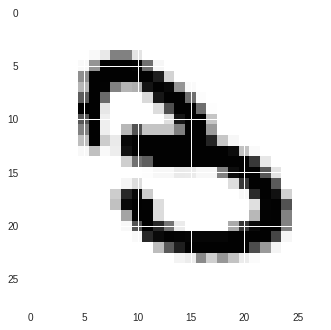

In [279]:
# display original image...
imshow(np.reshape(x_test[18],(28,28)),cmap = 'Greys')
print(y_test[18])


In [17]:
#load a saved model
#print its fitness - useful for identification of model
#get parameters <-- need to manually enter epochs
#create a new model with linear activation for output layer
model=load_model("drive/Colab Notebooks/MSIM607FinalProject/EvolutionFirst5Gens/model-12.h5")  #99.67 EvolutionFirst5Gens/model-12.h5
print(fitness(model))
get_params(model,12)
new_model = SoftMax2Linear(model)

#print(get_num_filters(model.layers[2]))
print(model.layers)
model.summary()

/usr/local/lib/python3.6/dist-packages/keras/models.py:318: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


0.9967
[2, 64, 4, 32, 3, 512, 1, 0.5, 0.4, 512, <keras.optimizers.Adadelta object at 0x7f0abac745c0>, 12]
32
[<keras.layers.convolutional.Conv2D object at 0x7f0ac6bd8908>, <keras.layers.normalization.BatchNormalization object at 0x7f0ac6bd8240>, <keras.layers.convolutional.Conv2D object at 0x7f0ac6bd89b0>, <keras.layers.pooling.MaxPooling2D object at 0x7f0ac6bba9e8>, <keras.layers.convolutional.Conv2D object at 0x7f0abadb9a90>, <keras.layers.pooling.MaxPooling2D object at 0x7f0abaf25d30>, <keras.layers.core.Dropout object at 0x7f0abad6ea90>, <keras.layers.core.Flatten object at 0x7f0abad6e860>, <keras.layers.core.Dense object at 0x7f0abadb9860>, <keras.layers.normalization.BatchNormalization object at 0x7f0abad4cbe0>, <keras.layers.core.Dropout object at 0x7f0abad6e898>, <keras.layers.core.Dense object at 0x7f0abace8f28>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2_1 (Conv2D)             (None

examine 11


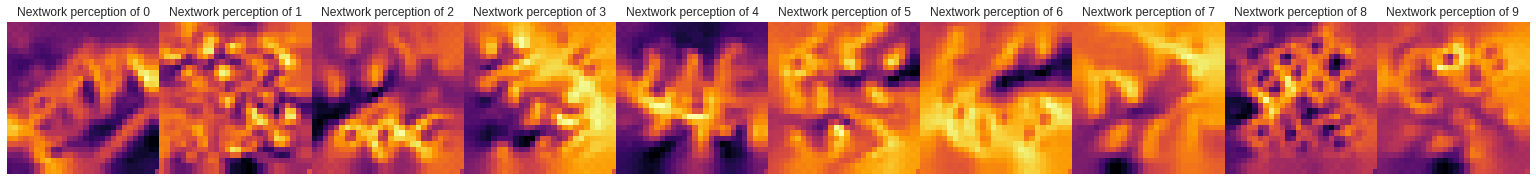

In [16]:
#what each class looks like according to the network the ideal networks

#select layer for visualization
ly_indx = utils.find_layer_idx(model, 'predict')
print('examine',ly_indx)
all_images = []

#for each class create visualization of ideal image
for idx in np.arange(10):
    img = visualize_activation(new_model, ly_indx, filter_indices=idx ,input_range=(-.5, .75))
    all_images.append(img)

#sequentially append each image into the created grid.  avoid position 0 as its colour map is gray
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.figure(num=2,figsize=(30,30))
grid = gridspec.GridSpec(2, len(all_images)+1, wspace=0.)

for i in range(0, len(all_images)):
  render_img_on_grid(all_images[i][...,0], i+1, grid)
  plt.title("Nextwork perception of " + str(i))

plt.show()
#plt.savefig("drive/Colab Notebooks/MSIM607FinalProject/VisualizeClassActivation-HandModel-5+75.jpg")    

examine 4


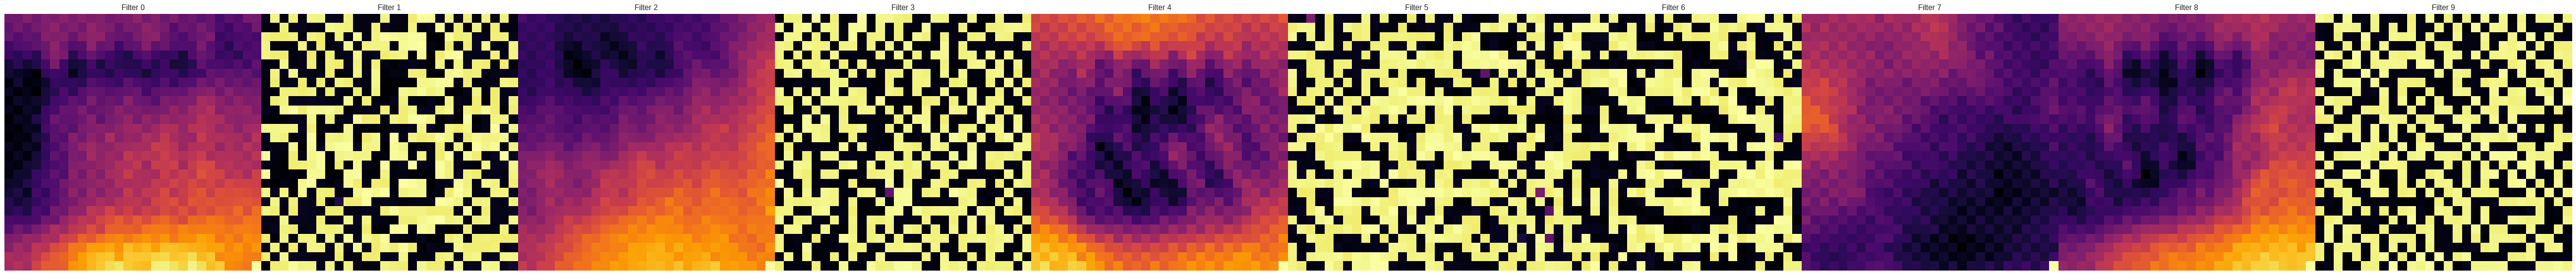

In [117]:
#what pattern activates a filter

#for other than the output layer... look at all filters in layer
ly_indx = utils.find_layer_idx(model, 'conv2_3')
print('examine',ly_indx)
all_images = []

for idx in np.arange(32):
    img = visualize_activation(model, ly_indx, filter_indices=idx,input_range = (-.75,.75),grad_modifier='relu')
    all_images.append(img)

#for all images created, fit into grid skipping first position as colour map set to gray
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.figure(num=2,figsize=(80,80))
grid = gridspec.GridSpec(2, len(all_images)+1, wspace=0.)

for i in range(0, len(all_images)):
  render_img_on_grid(all_images[i][...,0], i+1, grid)
  plt.title("Filter " + str(i))
 
plt.show()
#plt.savefig("drive/Colab Notebooks/MSIM607FinalProject/VisualizeFilterActivation-conv2_3-inferno-75+75-relu.jpg")    

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


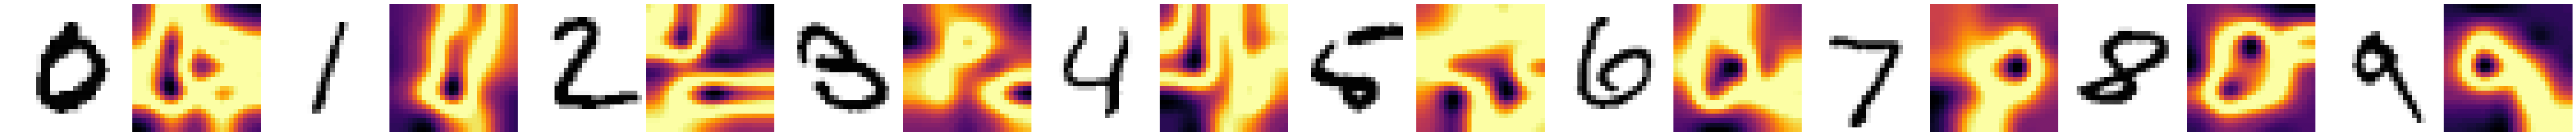

In [132]:
#class activation on input images based on input to layer (ie. output from prior layer)
#img_no = 51
ly_indx = utils.find_layer_idx(model, 'predict')
all_images_cam = []

for class_idx in np.arange(10):    
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    img_no = indices[0]
    all_images_cam.append(np.reshape(x_test[img_no],(28,28)))
    img_ca = visualize_cam(new_model, ly_indx, filter_indices = class_idx, seed_input = x_test[img_no], backprop_modifier = 'guided')
    gray = np.mean(img_ca, -1)  # must convert to grayscale.  visualize_saliency outputs an image with colormap of jet
    all_images_cam.append(gray)
    
plt.figure(num=2,figsize=(80,80))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
grid = gridspec.GridSpec(1, len(all_images_cam), wspace=0.)

#print all images sequentially into grid.  every other image is original image and is in gray colour map    
for i in range(0,len(all_images_cam)):
    ax = plt.subplot(grid[i])
    if (i % 2):
      plt.set_cmap('inferno')
    else:
      plt.set_cmap('Greys')
    ax.imshow(all_images_cam[i])
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()
#plt.savefig("drive/Colab Notebooks/MSIM607FinalProject/VisualizeCamClassInput-inferno-guided.jpg")  

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


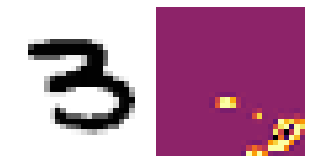

In [154]:
#activation on input images for convolution layer (ie activation of inbound image to layer)
img_no = 51
ly_indx = utils.find_layer_idx(model, 'conv2d-2')
idx = classOfImage(img_no)

img_ca = visualize_cam(model, ly_indx, filter_indices = idx, seed_input = x_test[img_no])
gray = np.mean(img_ca, -1)  # must convert to grayscale.  visualize_saliency outputs an image with colormap of jet

#prints original image and matching visualization 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
grid = gridspec.GridSpec(1, 3, wspace=0.)
render_img_on_grid(np.reshape(x_test[img_no],(28,28)), 0, grid)
ax1 = render_img_on_grid(gray, 1, grid)

plt.show()
#plt.savefig("drive/Colab Notebooks/MSIM607FinalProject/VisualizeCam-51class3-None-L4.jpg") 

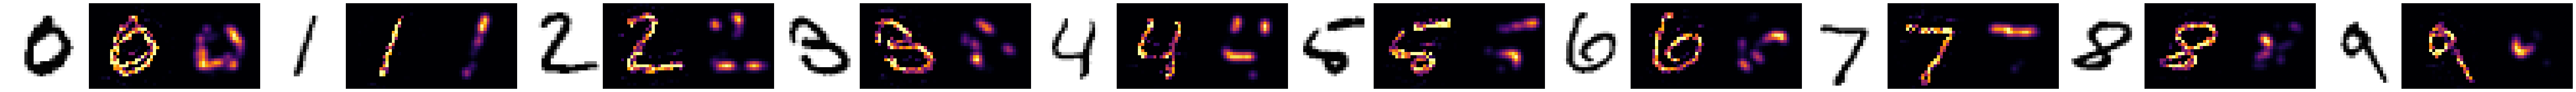

In [20]:
#visual saliency output layer - what pixels contribute to an image for a complete set of digits
ly_indx = utils.find_layer_idx(model, 'predict')
all_images_cam = []

#for each class create three images: original, saliency map, saliency map + blur
for class_idx in np.arange(10):    
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    img_no = indices[0]
    all_images_cam.append(np.reshape(x_test[img_no],(28,28)))
    img_vs = visualize_saliency(new_model, ly_indx, filter_indices = class_idx, seed_input = x_test[img_no], grad_modifier = 'relu', backprop_modifier='guided')
    gray = np.mean(img_vs, -1)  # must convert to grayscale.  visualize_saliency outputs an image with colormap of jet
    #create image with gaussian blur
    smoothe = ndimage.gaussian_filter(img_vs[:,:,0], sigma=1)  # change from 0 to 1 if using negative grad_modifier
    all_images_cam.append(gray)
    all_images_cam.append(smoothe)

    
plt.figure(num=2,figsize=(100,100))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
grid = gridspec.GridSpec(1, len(all_images_cam), wspace=0.)

# output all images sequentially with every third image needed a colour map of gray (original image)   
for i in range(0,len(all_images_cam)):
    ax = plt.subplot(grid[i])
    if (i % 3):
      plt.set_cmap('inferno')
    else:
      plt.set_cmap('Greys')
    ax.imshow(all_images_cam[i])
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()
#plt.savefig("drive/Colab Notebooks/MSIM607FinalProject/SaliencyClassAllDigits-inferno-relu-guided.jpg")  

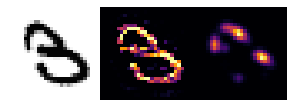

In [25]:
#visual saliency of output layer - which pixels contribute to classification - for an individual selected image
img_no = 18
ly_indx = utils.find_layer_idx(model, 'predict')
idx = classOfImage(img_no)

img_vs = visualize_saliency(new_model, ly_indx, filter_indices = idx, seed_input = x_test[img_no], grad_modifier = 'relu', backprop_modifier='guided')
gray = np.mean(img_vs, -1)  # must convert to grayscale.  visualize_saliency outputs an image with colormap of jet
#gaussian blur applied to saliency map
smoothe = ndimage.gaussian_filter(img_vs[:,:,0], sigma=1)  # change from 0 to 1 if using negative grad_modifier

plt.figure()
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
grid = gridspec.GridSpec(1, 3, wspace=0.)
render_img_on_grid(np.reshape(x_test[img_no],(28,28)), 0, grid)

ax1 = render_img_on_grid(gray, 1, grid)
ax2 = render_img_on_grid(smoothe, 2, grid)
plt.show()
#plt.savefig("drive/Colab Notebooks/MSIM607FinalProject/Saliency-18-inferno-class8-relu-guided.jpg")

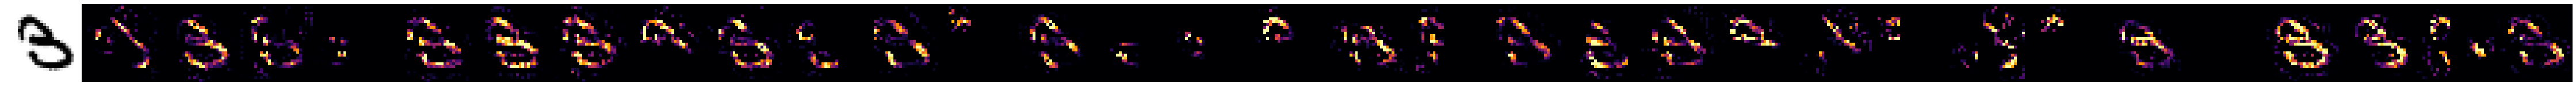

In [96]:
# visual saliency of convolution layer for a particular image - what pixels of image trigger convolution layer
image_no = 18
ly_indx = utils.find_layer_idx(model, 'conv2_3')
#filters = np.arange(get_num_filters(model.layers[0]))
all_images_l = []

#for each filter create an image
for idx in np.arange(32):
  img_vsc = visualize_saliency(new_model, ly_indx, filter_indices = idx, seed_input = x_test[image_no], grad_modifier = 'relu', backprop_modifier='guided')
  gray = np.mean(img_vsc, -1)  # must convert to grayscale.  visualize_saliency outputs an image with colormap of jet
  all_images_l.append(gray)
  
#prints individual image along with selected filters 
plt.figure(num=2,figsize=(80,80))  
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
grid = gridspec.GridSpec(1, len(all_images_l)+1, wspace=0.)
render_img_on_grid(np.reshape(x_test[image_no],(28,28)), 0, grid)

for i in range(0,len(all_images_l)):
  render_img_on_grid(all_images_l[i], i+1, grid)

plt.show()
#plt.savefig("drive/Colab Notebooks/MSIM607FinalProject/FilterSaliency-conv2_3-18-inferno-relu-guided.jpg")